In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels. api as sm
import statsmodels.formula.api as smf
import sys, os
import ast
import re
import seaborn as sns
import inspect

In [2]:
CURRENTDIR = os.path.dirname(os.path.dirname(os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))))
results = pd.read_excel(os.path.join(CURRENTDIR,"data/extracted_data.xlsx"))

In [13]:
# 0 = 'T'; 'M' = 1; 'R':2
human = {1:	0, 2:	1, 3:	1, 4:	0, 5:	0, 6:	0, 7:	1, 8:	1, 9:	1, 10:	0, 11:	1, 12:	1, 13:	1, 14:	1, 15:	0, 16:	1, 17:	1, 18:	1, 19:	1, 20:	1, 21:	1, 22:	0, 23:	1, 24:	1, 25:	1}
results['human'] = results.apply(lambda x: human[x.locutor] if x.conv == 1 else 2, axis=1)

# Loading sklearn Scalers & PCA

In [5]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [6]:
results.columns

Index(['file', 'locutor', 'block', 'conv', 'it', 'conv_id_unif', 'tier',
       'count_syllables', 'extract_sentiment', 'extract_subjectivity',
       'lexical_richness', 'linguistic_complexity', 'mean_ipu_lgth', 'nb_ipu',
       'nb_tokens', 'qt_discourse', 'qt_feedback', 'qt_filled_pause',
       'ratio_discourse', 'ratio_feedback', 'ratio_filled_pause',
       'ratio_silence_lgth', 'speech_rate', 'speech_rate_2', 'speech_rate_max',
       'speech_rate_mean', 'speech_rate_min', 'sum_ipu_lgth', 'extract_text',
       'human'],
      dtype='object')

In [7]:
int_cols = ['count_syllables', 
       'lexical_richness', 'linguistic_complexity', 'mean_ipu_lgth', 'nb_ipu',
       'nb_tokens', 'ratio_discourse', 'ratio_feedback', 'ratio_filled_pause',
       'ratio_silence_lgth', 'speech_rate', 'speech_rate_mean', 'sum_ipu_lgth']
labels = 'locutor'
select_tier = 'participant'

In [18]:
X_H = results[(results.tier == select_tier) & (results.conv == 1)][int_cols]
X_R = results[(results.tier == select_tier) & (results.conv == 2)][int_cols]
y_H = results[(results.tier == select_tier) & (results.conv == 1)][labels]
y_R = results[(results.tier == select_tier) & (results.conv == 2)][labels]

In [19]:
X_Hs = StandardScaler().fit_transform(X_H)

In [20]:
X_Hs.shape

(297, 13)

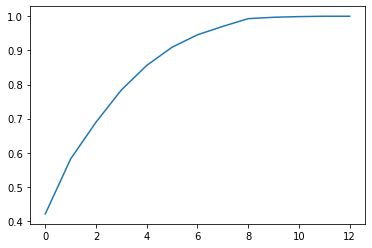

In [21]:
pca = PCA()
pca.fit(X_Hs)
plt.plot(np.cumsum(pca.explained_variance_ratio_))

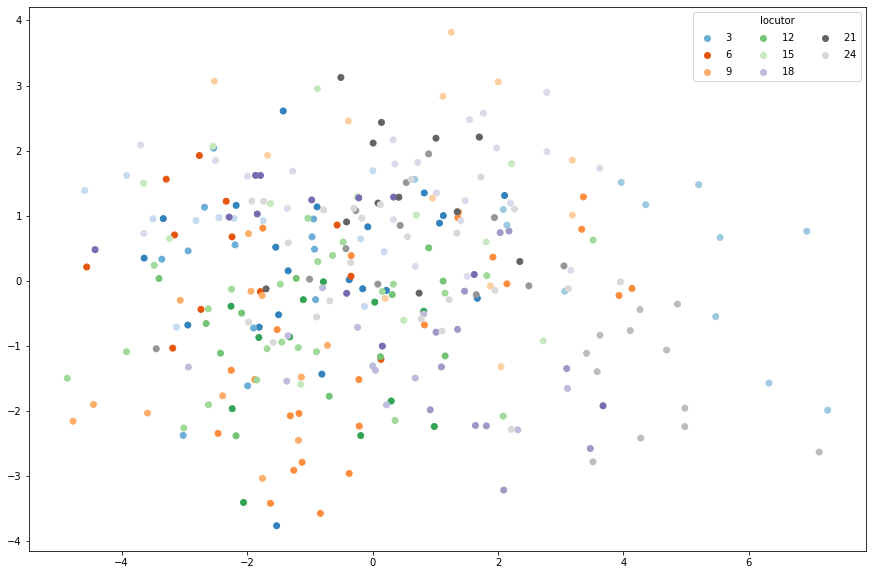

In [22]:
X_Hss = pca.transform(X_Hs)
fig, ax = plt.subplots(figsize = (15,10))
scat = ax.scatter(X_Hss[:,0], X_Hss[:,1], c=y_H, cmap=plt.get_cmap('tab20c'))
legend = ax.legend(*scat.legend_elements(), loc="best", title=labels, ncol=3)
plt.show()

First two PCA components represent a very low share of the total variance still some patterns appear.

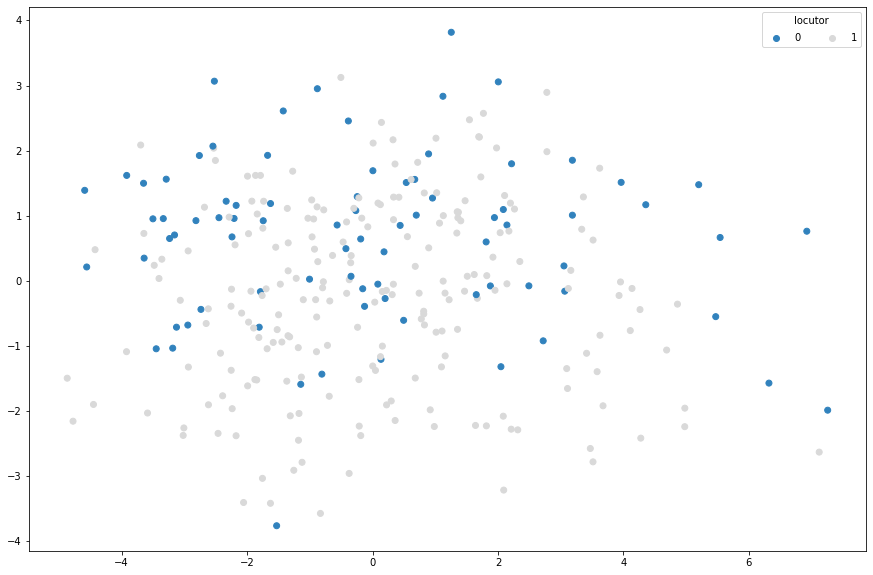

In [23]:
y_HH = results[(results.tier == 'conversant') & (results.conv == 1)]['human']
fig, ax = plt.subplots(figsize = (15,10))
scat = ax.scatter(X_Hss[:,0], X_Hss[:,1], c=y_HH, cmap=plt.get_cmap('tab20c'))
legend = ax.legend(*scat.legend_elements(), loc="best", title=labels, ncol=3)
plt.show()

In [48]:
y_H2 = results[(results.tier == select_tier) & (results.conv == 1)].apply(lambda x: "{}_{}".format(x.locutor, x.conv_id_unif), axis=1).values

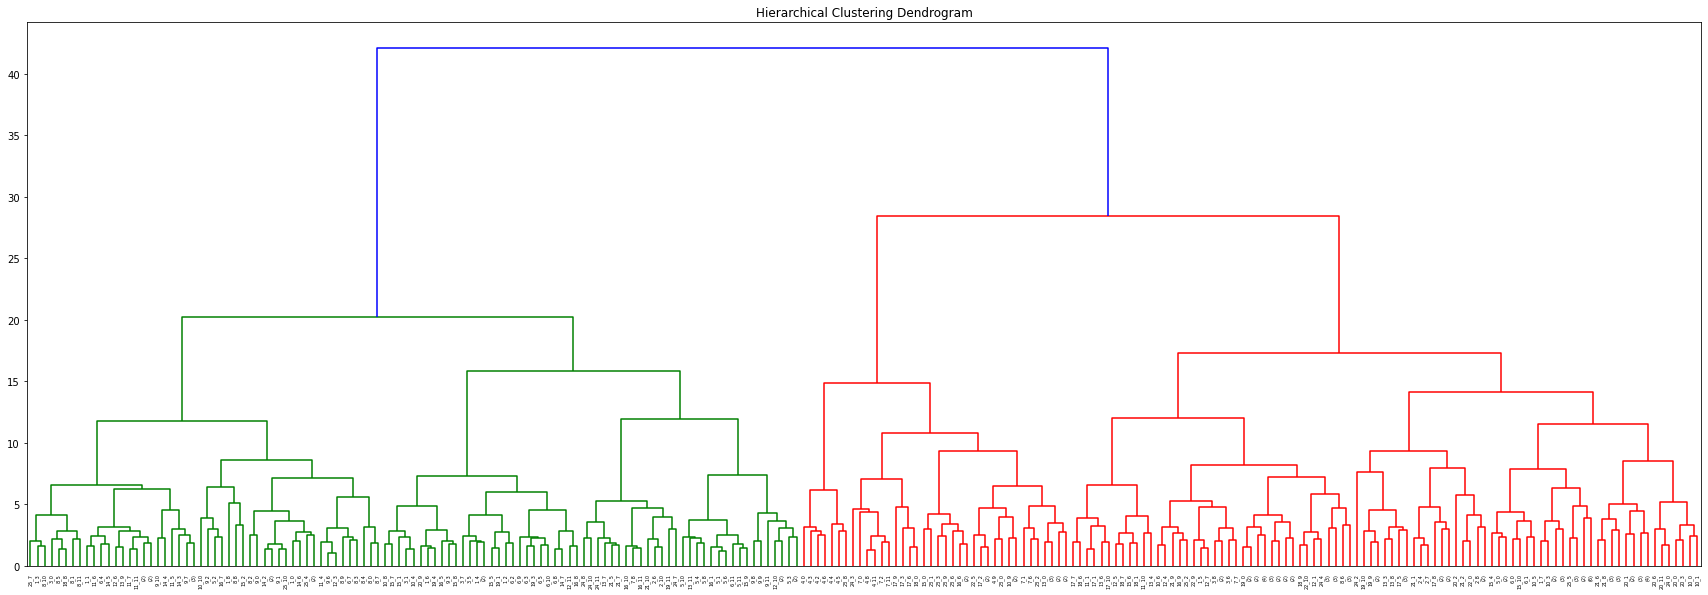

In [50]:
from scipy.cluster.hierarchy import dendrogram
from sklearn.datasets import load_iris
from sklearn.cluster import AgglomerativeClustering

def plot_dendrogram(model, index, **kwargs):
    # Create linkage matrix and then plot the dendrogram
    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0]) 
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples: 
                current_count += 1 # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count
    
    linkage_matrix = np.column_stack([model.children_, model.distances_, counts]).astype(float) 
    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, labels=index, **kwargs)

# setting distance_threshold=0 ensures we compute the full tree.
model = AgglomerativeClustering(distance_threshold=0, n_clusters=None)
model = model.fit(pd.DataFrame(X_Hss, index=y_H2))
_ = plt.subplots(figsize=(30,10))
plt.title('Hierarchical Clustering Dendrogram')
# plot the top three levels of the dendrogram 
plot_dendrogram(model, y_H2, truncate_mode='level', p=8) 
plt.show()

Conclusion: some individual clusters

**Looking at conversant - human agent**

In [26]:
X_H = results[(results.tier == 'conversant') & (results.conv == 1)][int_cols]
y_H = results[(results.tier == 'conversant') & (results.conv == 1)][labels]
y_HH = results[(results.tier == 'conversant') & (results.conv == 1)]['human']


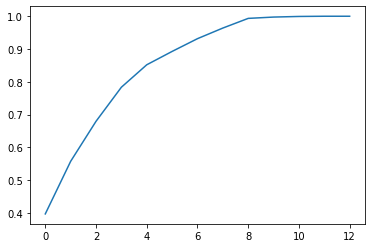

In [27]:
X_Hs = StandardScaler().fit_transform(X_H)
pca = PCA()
pca.fit(X_Hs)
plt.plot(np.cumsum(pca.explained_variance_ratio_))

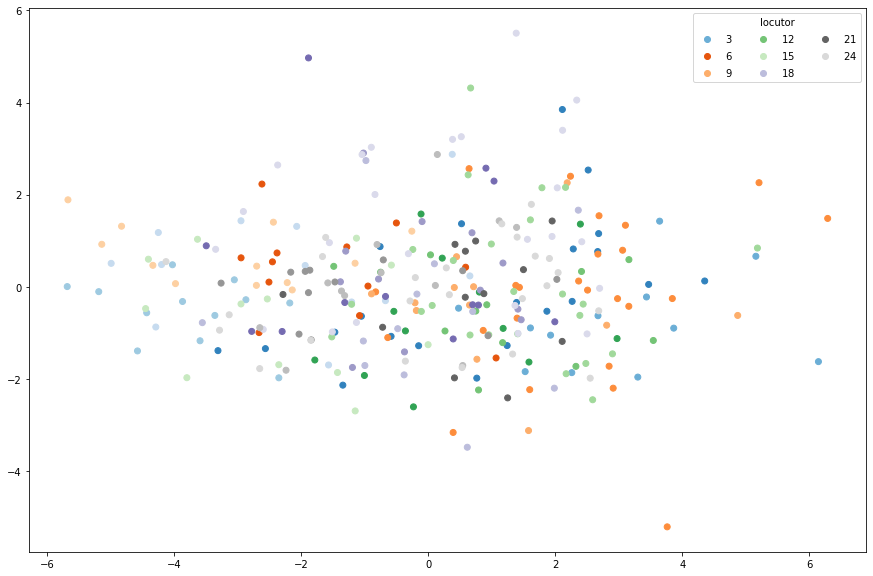

In [28]:
X_Hss = pca.transform(X_Hs)
fig, ax = plt.subplots(figsize = (15,10))
scat = ax.scatter(X_Hss[:,0], X_Hss[:,1], c=y_H, cmap=plt.get_cmap('tab20c'))
legend = ax.legend(*scat.legend_elements(), loc="best", title=labels, ncol=3)
plt.show()

Only two people taking to 24 others: way more condensed plot

Now trying out with which person that was:

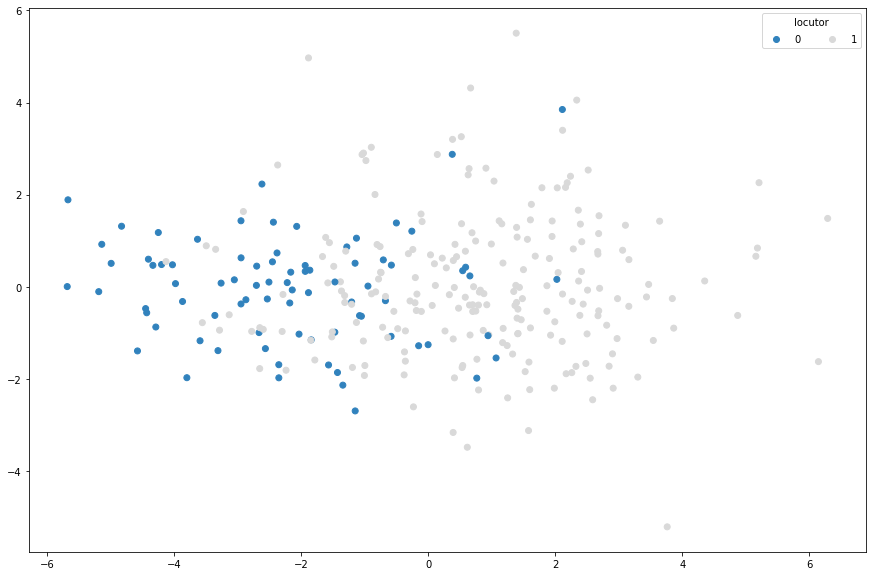

In [29]:
fig, ax = plt.subplots(figsize = (15,10))
scat = ax.scatter(X_Hss[:,0], X_Hss[:,1], c=y_HH, cmap=plt.get_cmap('tab20c'))
legend = ax.legend(*scat.legend_elements(), loc="best", title=labels, ncol=3)
plt.show()

In [16]:
y_H2 = results[(results.tier == 'conversant') & (results.conv == 1)].apply(lambda x: "{}_{}_{}".format(x.human, x.locutor, x.conv_id_unif), axis=1).values

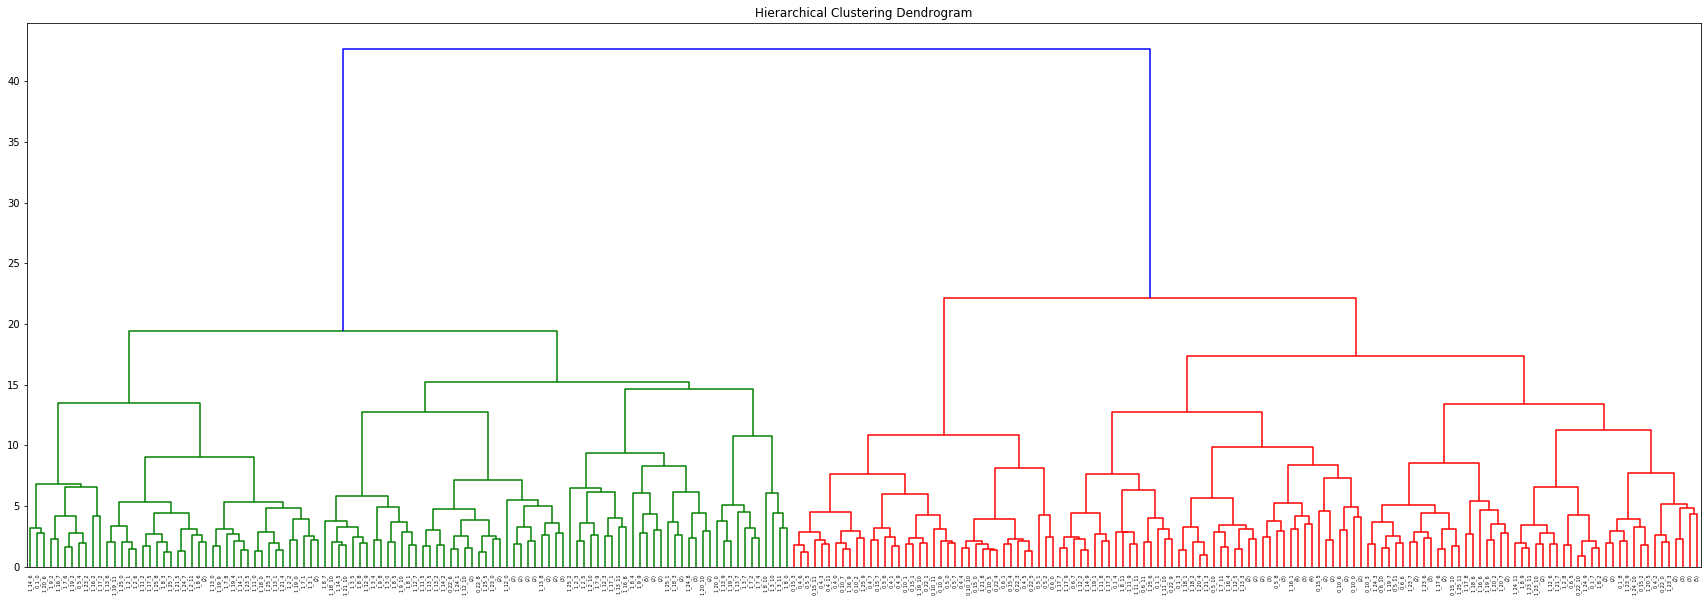

In [17]:
from scipy.cluster.hierarchy import dendrogram
from sklearn.datasets import load_iris
from sklearn.cluster import AgglomerativeClustering

def plot_dendrogram(model, index, **kwargs):
    # Create linkage matrix and then plot the dendrogram
    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0]) 
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples: 
                current_count += 1 # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count
    
    linkage_matrix = np.column_stack([model.children_, model.distances_, counts]).astype(float) 
    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, labels=index, **kwargs)

# setting distance_threshold=0 ensures we compute the full tree.
model = AgglomerativeClustering(distance_threshold=0, n_clusters=None)
model = model.fit(pd.DataFrame(X_Hss, index=y_H2))
_ = plt.subplots(figsize=(30,10))
plt.title('Hierarchical Clustering Dendrogram')
# plot the top three levels of the dendrogram 
plot_dendrogram(model, y_H2, truncate_mode='level', p=8) 
plt.show()

In terms of participant, more evenly distributed eventhough some clusters remain.
In terms of agent, strong groupings appear.

Are those separable? (naive classifiers but pretty plots)

In [38]:
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

classifiers = {'NB':GaussianNB(), 'QDA':QuadraticDiscriminantAnalysis(), 'SVM': SVC(), 'Trees':RandomForestClassifier()}

In [36]:
X = X_Hss # bc I don't want to adapt the code below
X_train, X_test, y_train, y_test = train_test_split(X[:,:2], y_HH)

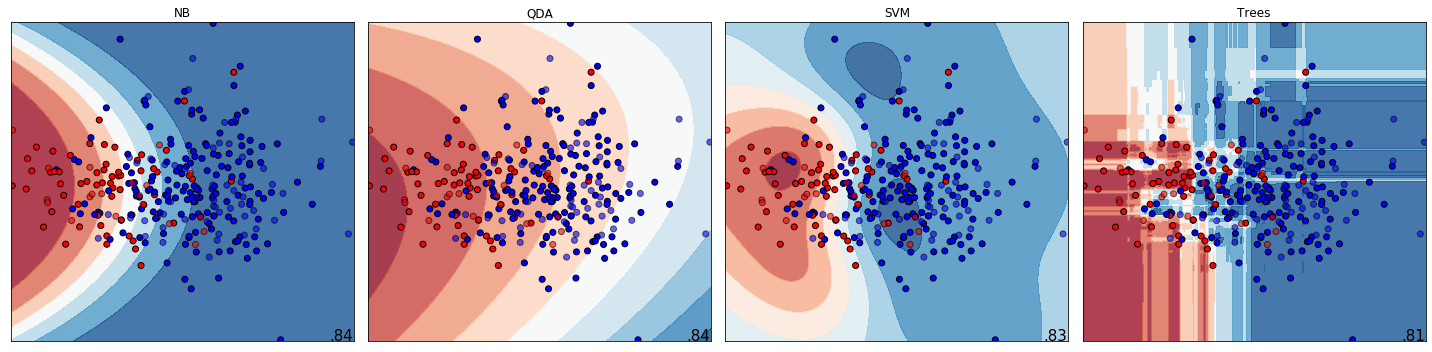

In [44]:
from matplotlib.colors import ListedColormap

cm = plt.cm.RdBu
cm_bright = ListedColormap(['#FF0000', '#0000FF'])
h = .02
x_min, x_max = X[:, 0].min() - .05, X[:, 0].max() + .05
y_min, y_max = X[:, 1].min() - .05, X[:, 1].max() + .05
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

f = plt.figure(figsize=(20,5))
for i, (k, clf) in enumerate(classifiers.items()):
    #ax = plt.subplot(1, len(classifiers), i+1)
    ax = f.add_subplot('1{}{}'.format(len(classifiers), i+1))
    clf.fit(X_train, y_train)
    score = clf.score(X_test, y_test)
    if hasattr(clf, "decision_function"):
        Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
    else:
        Z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]
    # Put the result into a color plot
    Z = Z.reshape(xx.shape)
    ax.contourf(xx, yy, Z, cmap=cm, alpha=.8)
    # Plot the training points
    ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright, edgecolors='k')
    # Plot the testing points
    ax.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=cm_bright, edgecolors='k', alpha=0.6)

    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    ax.set_xticks(())
    ax.set_yticks(())
    ax.text(xx.max() - .03, yy.min() + .03, ('%.2f' % score).lstrip('0'), size=15, horizontalalignment='right')
    ax.set_title(k)

plt.tight_layout()
plt.show()

In [46]:
X_train, X_test, y_train, y_test = train_test_split(X, y_HH) # stratify = True
for i, (k, clf) in enumerate(classifiers.items()):
    clf.fit(X_train, y_train)
    print(k, clf.score(X_test, y_test))

NB 0.8266666666666667
QDA 0.8533333333333334
SVM 0.88
Trees 0.8133333333333334


For analysis: highly imbalanced dataset

In [47]:
y_HH.sum()/len(y_HH)

0.7272727272727273

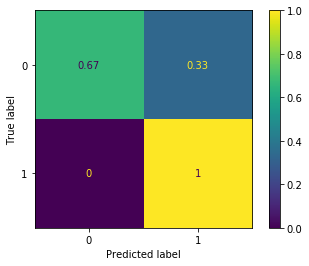

In [51]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_test, classifiers['SVM'].predict(X_test), normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1])
disp.plot(cmap='viridis')